In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features=0.3)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.02)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('Combined_all_3rd_fit.csv', encoding='cp1252')
print(data.columns.values)  

['Name' 'Coef_a' 'Coef_b' 'Coef_c' 'Coef_d' 'A_site' 'B_site' 'X_site'
 'Spacegroup' 'Ehull' 'BulkModulus' 'Energy' 'ZPE' 's_A' 's_B' 's_X'
 'density' 'mean_A2B' 'mean_A2X' 'mean_B2X' 'mean_X2X' 'std_A2B' 'std_A2X'
 'std_B2X' 'std_X2X' 'E_coh' 'TF' 'OF' 'A_Z' 'B_Z' 'X_Z' 'A_M' 'B_M' 'X_M'
 'A_G' 'B_G' 'X_G' 'A_IEI' 'B_IEI' 'X_IEI' 'A_IEII' 'B_IEII' 'X_IEII'
 'A_EA' 'B_EA' 'X_EA' 'A_ChiP' 'B_ChiP' 'X_ChiP' 'A_ChiA' 'X_ChiA'
 'A_Rvdw' 'B_Rvdw' 'X_Rvdw' 'A_Rc' 'B_Rc' 'X_Rc' 'A_Ra' 'B_Ra' 'X_Ra'
 'A_MP' 'B_MP' 'X_MP' 'A_BP' 'B_BP' 'X_BP' 'A_Rho' 'B_Rho' 'A_MV' 'B_MV'
 'X_MV' 'A_Hf' 'B_Hf' 'X_Hf' 'A_Hv' 'B_Hv' 'X_Hv' 'A_Kappa' 'B_Kappa'
 'X_Kappa' 'A_CvM' 'B_CvM' 'X_CvM' 'A_B' 'B_B' 'X_B' 'A_MendeleevNo'
 'B_MendeleevNo' 'X_MendeleevNo']


In [6]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup','BulkModulus',
           'Ehull','Energy','ZPE','Coef_b', 'Coef_c', 'Coef_a'], axis=1, inplace = True)
target = 'Coef_d'

In [7]:
data.fillna(0, inplace= True)
d=data.copy()
columns = list(d.columns.values)

# Standard Scaling

In [8]:
data_std=d.copy()
scaler=StandardScaler()
scaler.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_std= scaler.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [9]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 51)


### Test-train splitting 

In [10]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state =50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop(target)
X = df_train

Y_test = df_test.pop(target)
X_test = df_test

RF 0.8365190278493575
RMSE:  0.4062451384454664
RMSE unscaled:  4.36790883207581
----------------------------------------


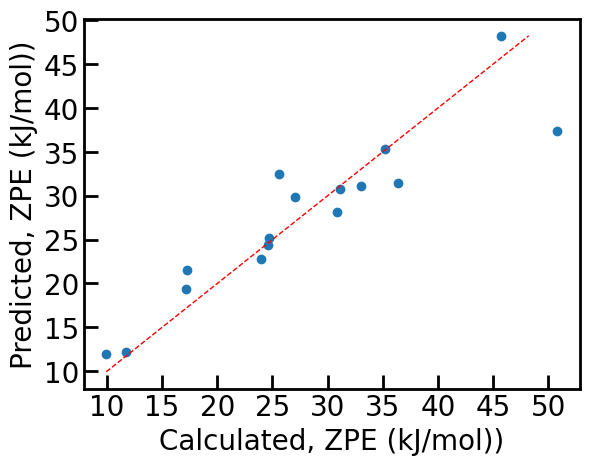

GB 0.8573650417636317
RMSE:  0.3794613615131239
RMSE unscaled:  4.079932226948187
----------------------------------------


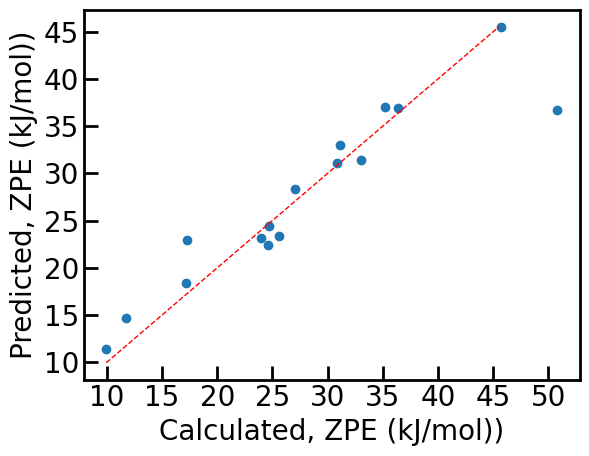

RR 0.9217091066438104
RMSE:  0.2811319437624491
RMSE unscaled:  3.0227037419759304
----------------------------------------


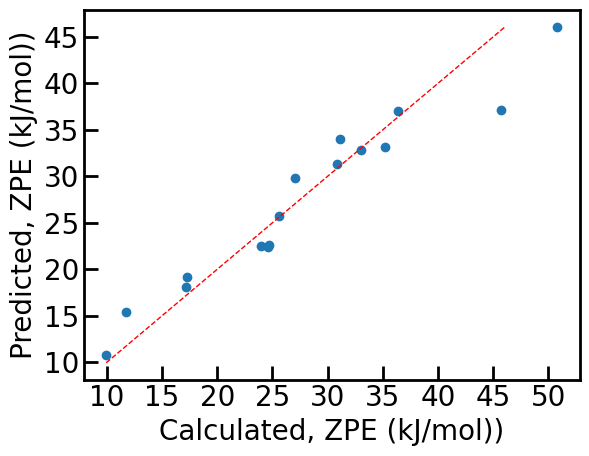

LASSO 0.9646319670998482
RMSE:  0.18895571159254004
RMSE unscaled:  2.031633719223
----------------------------------------


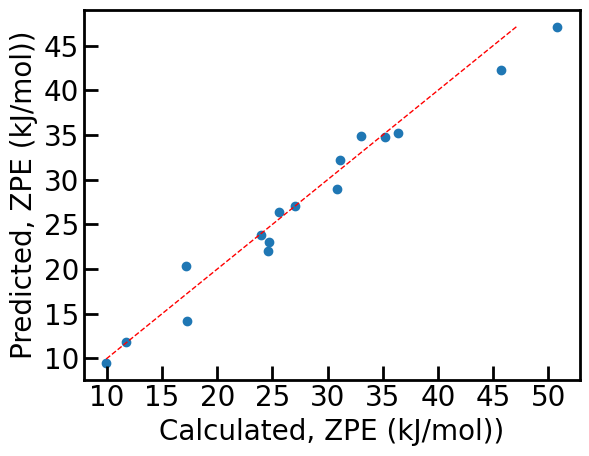

gpr1 0.9552325249258731
RMSE:  0.2125865927170706
RMSE unscaled:  2.2857106905033016
----------------------------------------


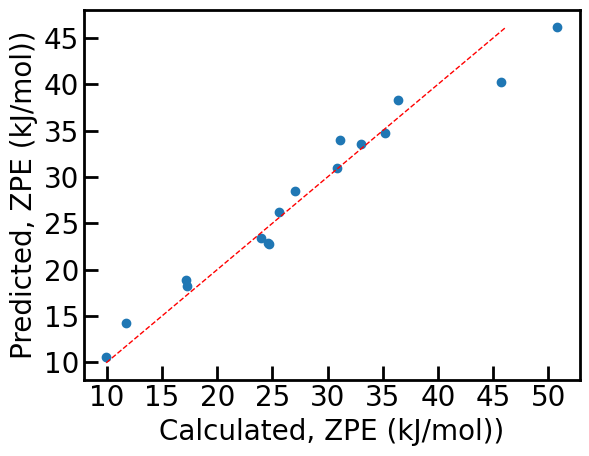

gpr2 0.9604159886036392
RMSE:  0.19990077253073443
RMSE unscaled:  2.1493139664808125
----------------------------------------


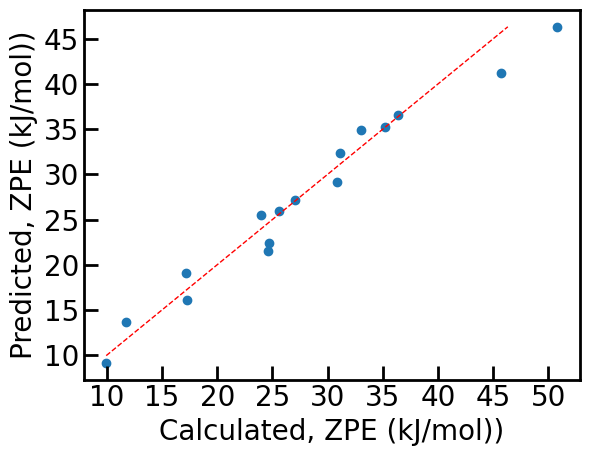

gpr3 0.9401048771612853
RMSE:  0.24589534143104794
RMSE unscaled:  2.6438431674848206
----------------------------------------


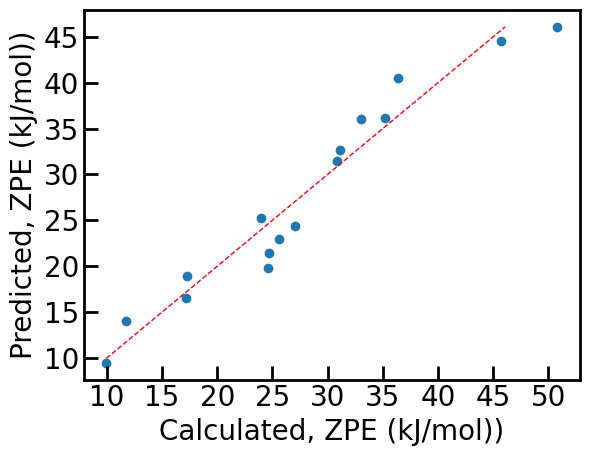

gpr4 0.9616037678753712
RMSE:  0.19687876447515043
RMSE unscaled:  2.11682162521342
----------------------------------------


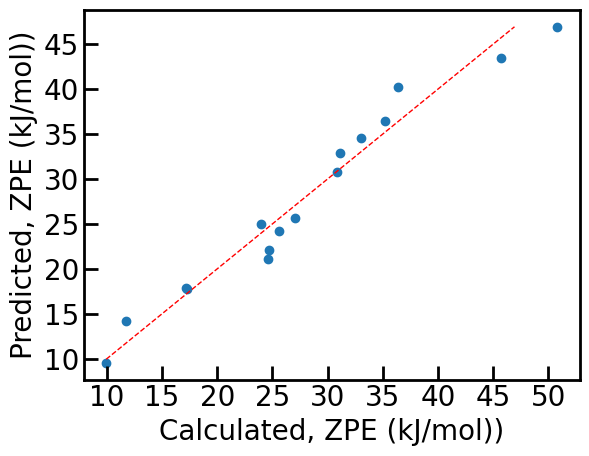

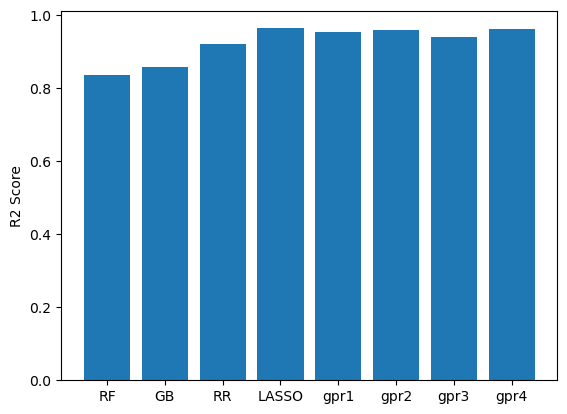

In [11]:
run_models()

In [12]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
28      X_EA  81.232938
35      X_Ra  54.221020
1        s_B  45.079280
25    X_IEII  44.130829
17       X_Z  43.753926
2        s_X  36.848803
4   mean_A2B  36.476139
7   mean_X2X  21.756733
0        s_A  21.365428
33    A_Rvdw  21.351495
20     A_IEI  18.448048
16       B_Z  16.733902
42      B_Hf  16.431242
5   mean_A2X  14.661730
34      B_Ra  14.611618
10   std_B2X  14.051080
14        OF  12.789702
26      A_EA  12.359494
31    A_ChiA  12.090829
9    std_A2X  10.602250
39     B_Rho   9.731500
12     E_coh   9.463266
29    A_ChiP   9.223658
47     B_CvM   8.515155
36      B_MP   8.146515
13        TF   6.853180
11   std_X2X   5.596058
43   A_Kappa   5.555247
37      A_BP   5.551490
41      X_MV   5.384953


In [13]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_IEII', 'X_Z', 's_X', 'mean_A2B',
       'mean_X2X', 's_A', 'A_Rvdw', 'A_IEI', 'B_Z', 'B_Hf', 'mean_A2X',
       'B_Ra', 'std_B2X', 'OF', 'A_EA', 'A_ChiA', 'std_A2X', 'B_Rho',
       'E_coh', 'A_ChiP', 'B_CvM', 'B_MP', 'TF', 'std_X2X', 'A_Kappa',
       'A_BP', 'X_MV', 'std_A2B', 'B_B', 'A_G', 'A_Z', 'B_MV', 'X_Kappa',
       'A_B', 'A_CvM', 'B_IEII', 'B_Kappa'], dtype=object)

In [14]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.8684923979350336
RMSE:  0.3643594185966904
RMSE unscaled:  3.9175575826666287
----------------------------------------


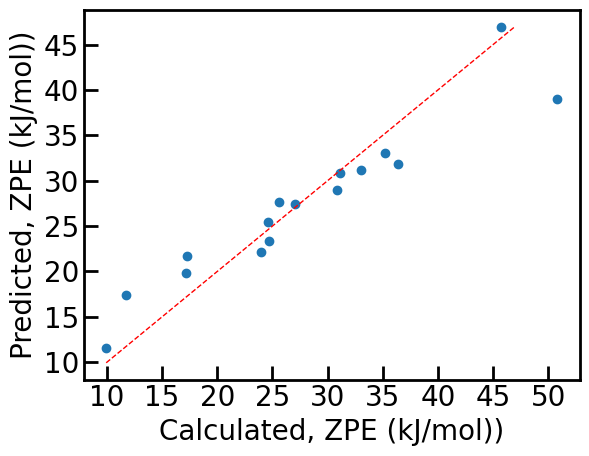

GB 0.7584492474764415
RMSE:  0.4938087355534386
RMSE unscaled:  5.309384244285776
----------------------------------------


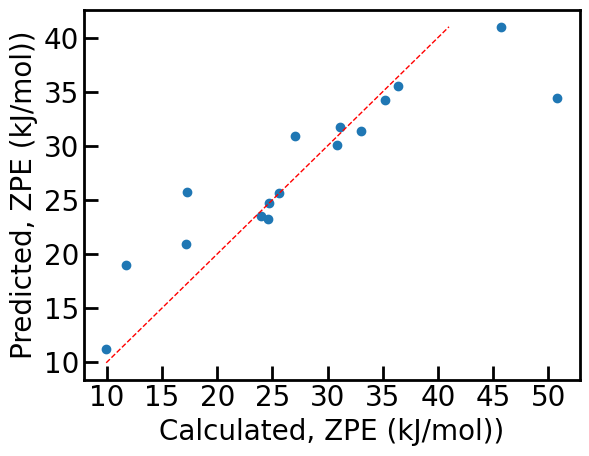

RR 0.9255876478891419
RMSE:  0.2740798369168289
RMSE unscaled:  2.9468801643853246
----------------------------------------


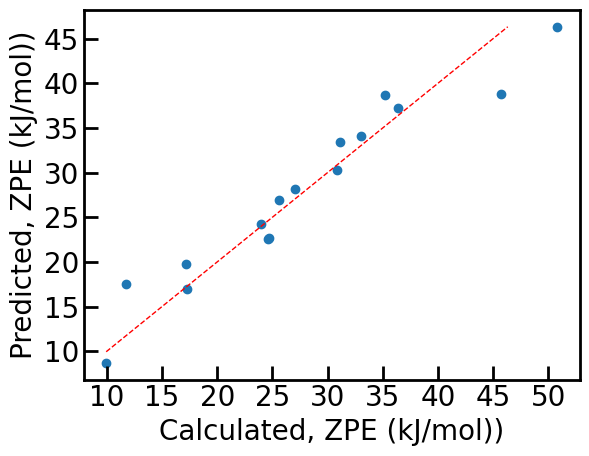

LASSO 0.9646070961627936
RMSE:  0.18902213710926505
RMSE unscaled:  2.032347920018825
----------------------------------------


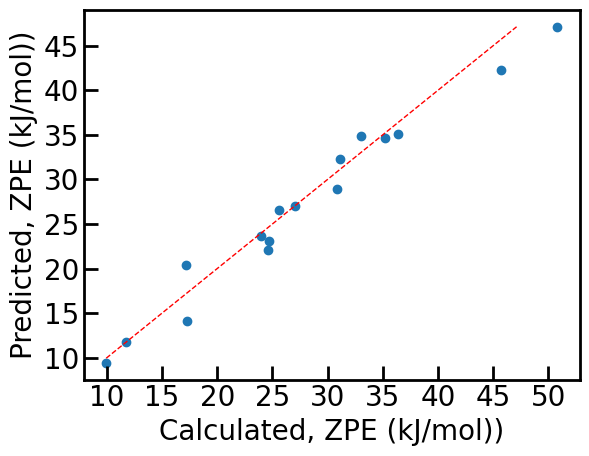

gpr1 0.9260702725698476
RMSE:  0.27318957561926577
RMSE unscaled:  2.9373081601531963
----------------------------------------


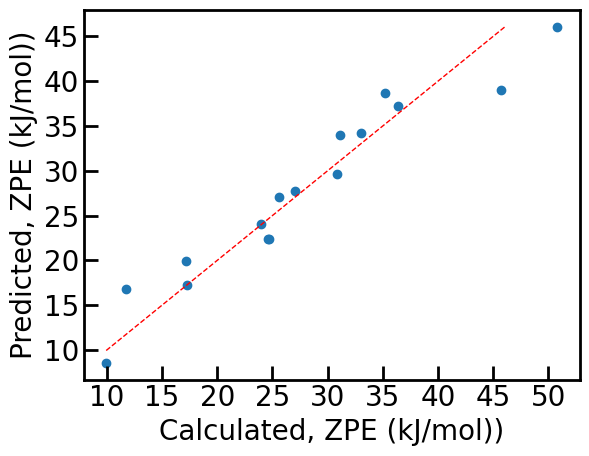

gpr2 0.9494180218280868
RMSE:  0.2259708794884702
RMSE unscaled:  2.4296172603727624
----------------------------------------


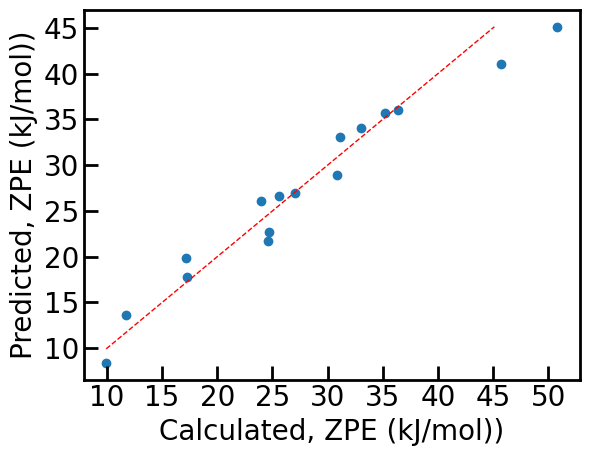

gpr3 0.9384839981652725
RMSE:  0.24920033487926477
RMSE unscaled:  2.6793781405989834
----------------------------------------


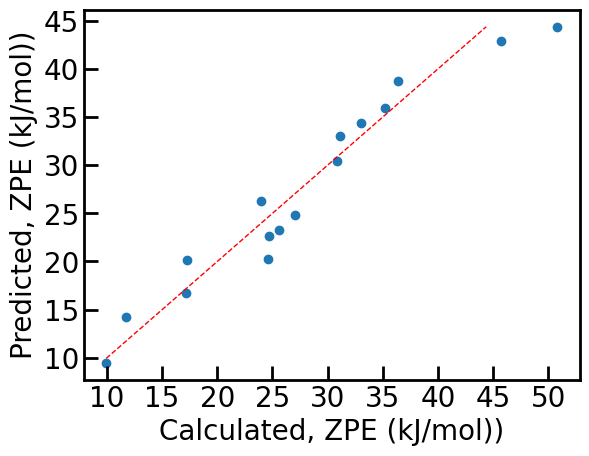

gpr4 0.9567309629430234
RMSE:  0.20899850814539445
RMSE unscaled:  2.247131948734644
----------------------------------------


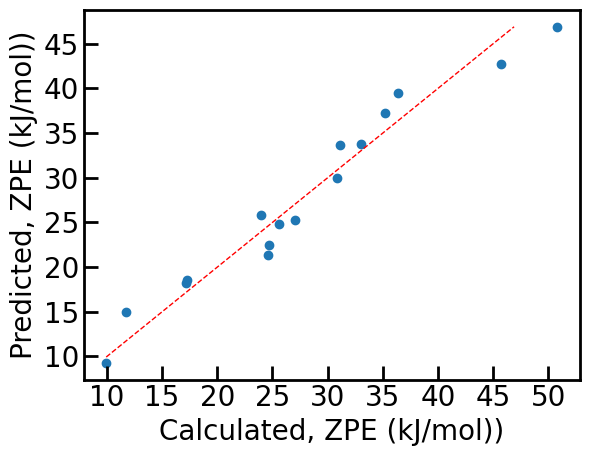

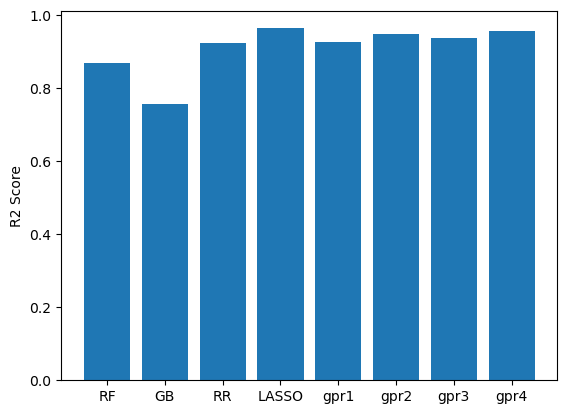

In [15]:
run_models()

In [16]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_IEII', 'X_Z', 's_X', 'mean_A2B',
       'mean_X2X', 's_A', 'A_Rvdw', 'A_IEI', 'B_Z', 'B_Hf', 'mean_A2X',
       'B_Ra', 'std_B2X', 'OF', 'A_EA', 'A_ChiA', 'std_A2X', 'B_Rho',
       'E_coh', 'A_ChiP', 'B_CvM', 'B_MP', 'TF', 'std_X2X', 'A_Kappa',
       'A_BP', 'X_MV'], dtype=object)

In [17]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9355510581086839
RMSE:  0.2550718116680799
RMSE unscaled:  2.742507696859842
----------------------------------------


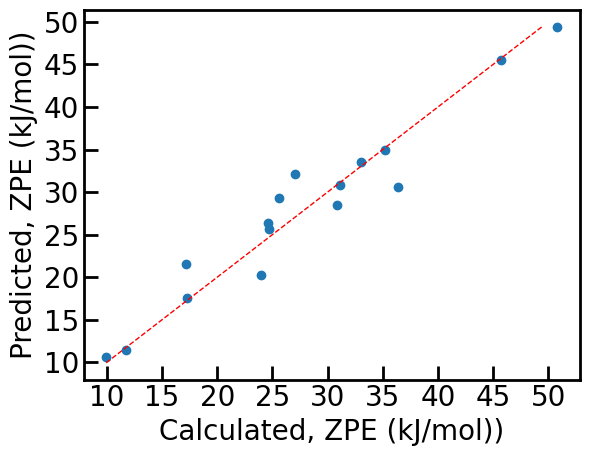

GB 0.7546702452710173
RMSE:  0.49765650281616813
RMSE unscaled:  5.350755069484967
----------------------------------------


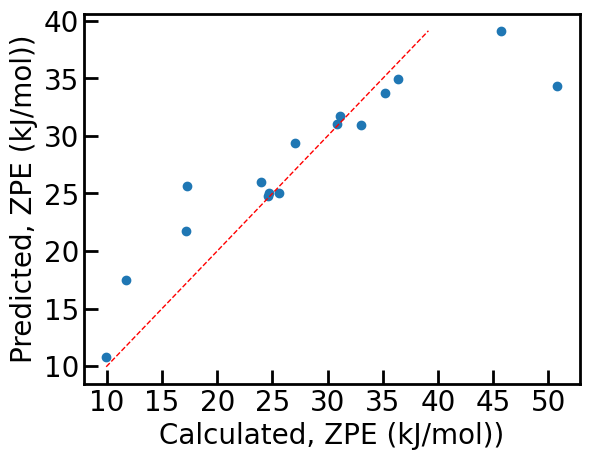

RR 0.9468522650825706
RMSE:  0.23163114346344954
RMSE unscaled:  2.4904758766821153
----------------------------------------


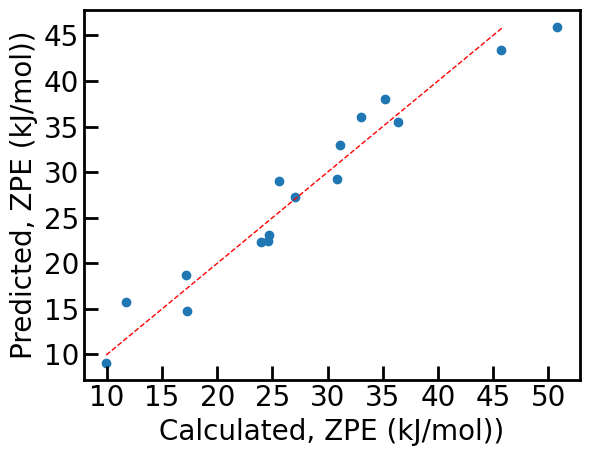

LASSO 0.9502468356836026
RMSE:  0.224111903653678
RMSE unscaled:  2.409629730187231
----------------------------------------


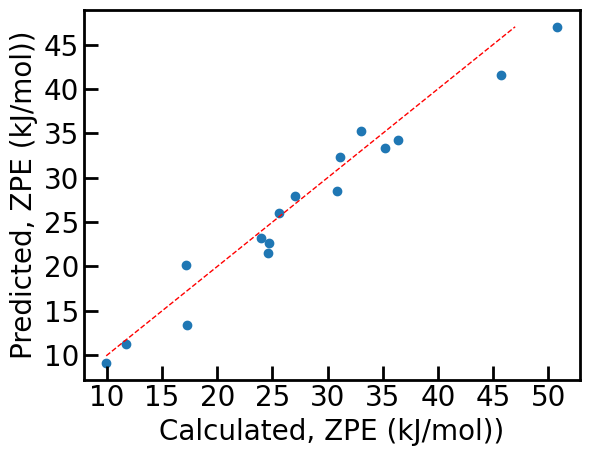

gpr1 0.9488249439229195
RMSE:  0.22729178253490662
RMSE unscaled:  2.4438194834563998
----------------------------------------


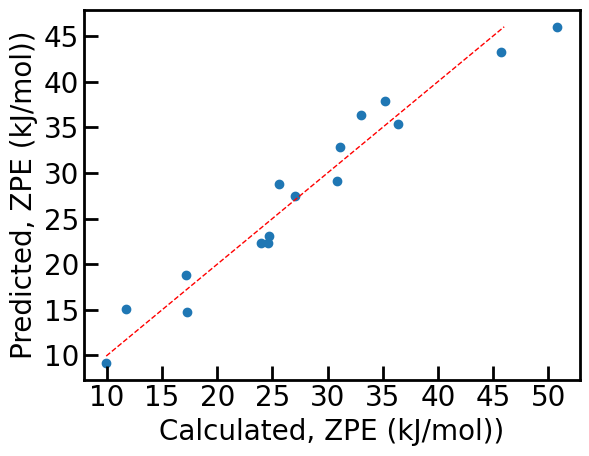

gpr2 0.9467366100153715
RMSE:  0.23188303338168714
RMSE unscaled:  2.4931841729654667
----------------------------------------


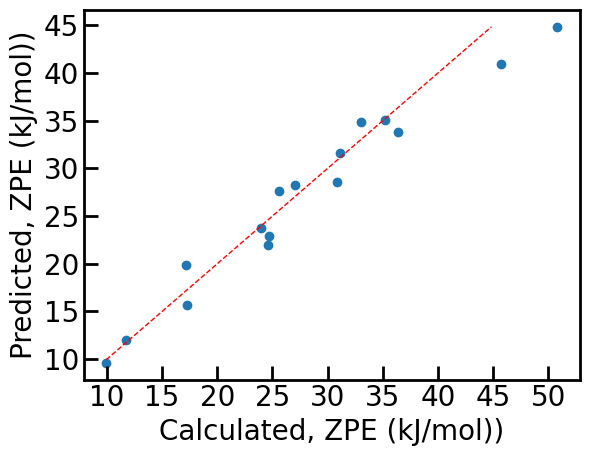

gpr3 0.9610280337293323
RMSE:  0.19834932642660552
RMSE unscaled:  2.132632966514523
----------------------------------------


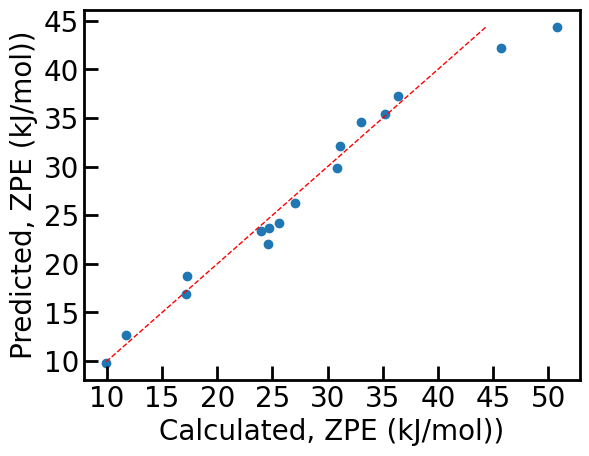

gpr4 0.9711174019925953
RMSE:  0.1707547127512377
RMSE unscaled:  1.8359383223605519
----------------------------------------


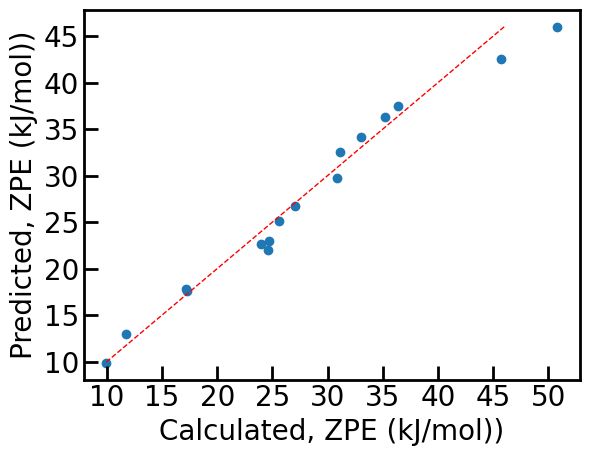

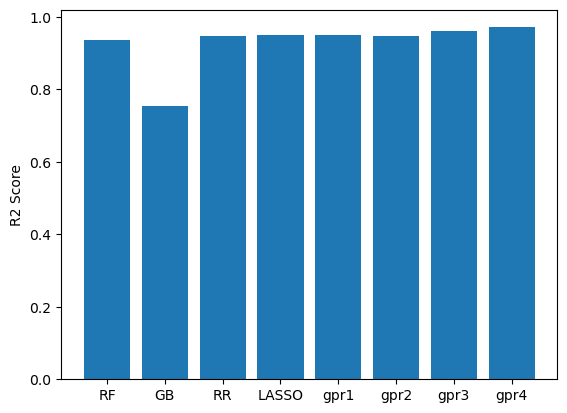

In [18]:
run_models()

In [19]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_IEII', 'X_Z', 's_X', 'mean_A2B',
       'mean_X2X', 's_A', 'A_Rvdw', 'A_IEI', 'B_Z', 'B_Hf', 'mean_A2X',
       'B_Ra', 'std_B2X', 'OF', 'A_EA', 'A_ChiA', 'std_A2X'], dtype=object)

In [20]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.908222994605578
RMSE:  0.30438378450078674
RMSE unscaled:  3.2727053073156203
----------------------------------------


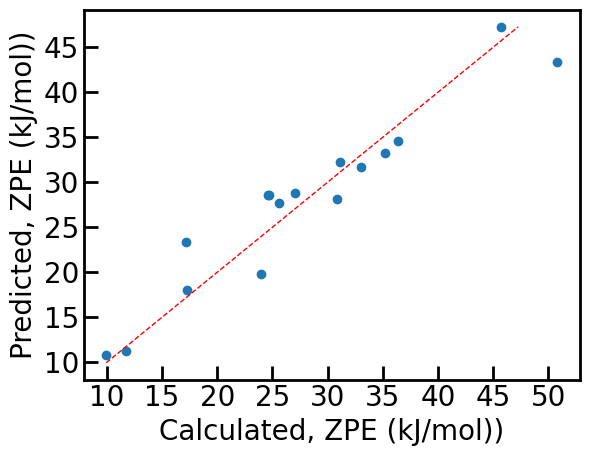

GB 0.77176911386452
RMSE:  0.480000598873154
RMSE unscaled:  5.160920480778065
----------------------------------------


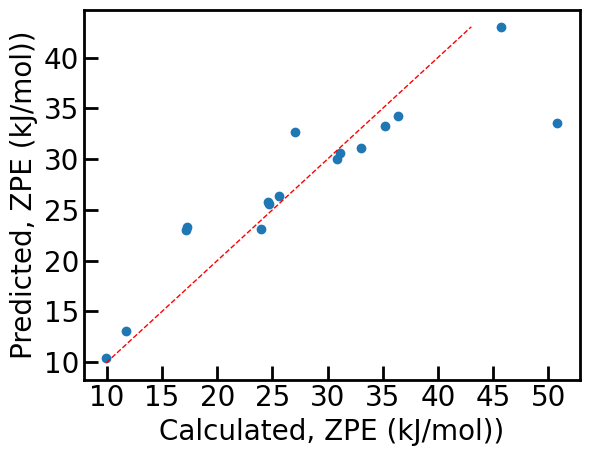

RR 0.9422175408567814
RMSE:  0.24151971160704938
RMSE unscaled:  2.59679681456778
----------------------------------------


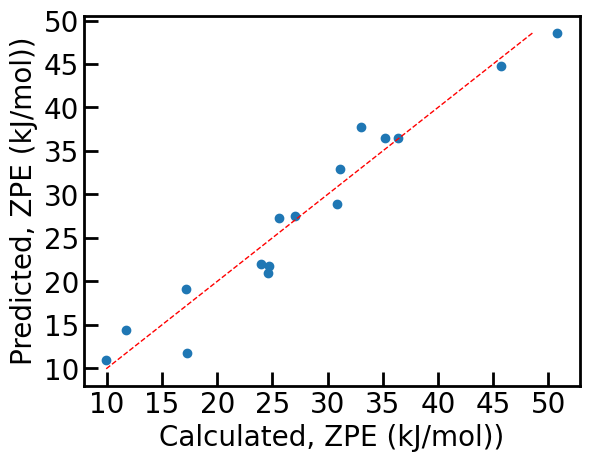

LASSO 0.9510538586395555
RMSE:  0.22228686510372248
RMSE unscaled:  2.3900070904388917
----------------------------------------


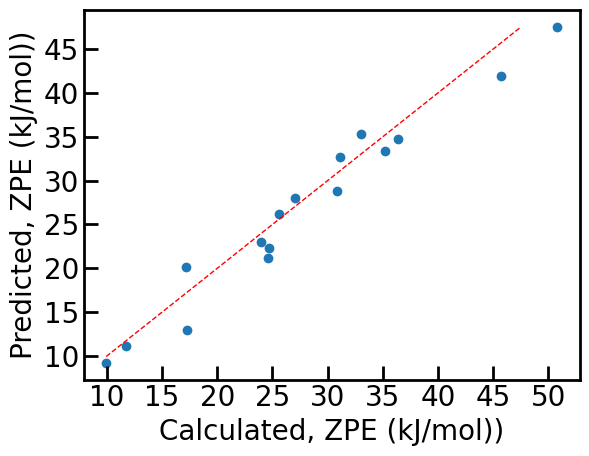

gpr1 0.949505833140694
RMSE:  0.2257746493328636
RMSE unscaled:  2.427507412528002
----------------------------------------


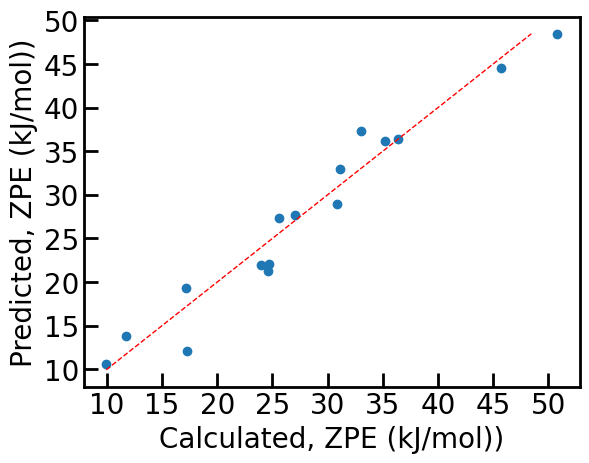

gpr2 0.9609347460972191
RMSE:  0.19858658003431504
RMSE unscaled:  2.135183894588449
----------------------------------------


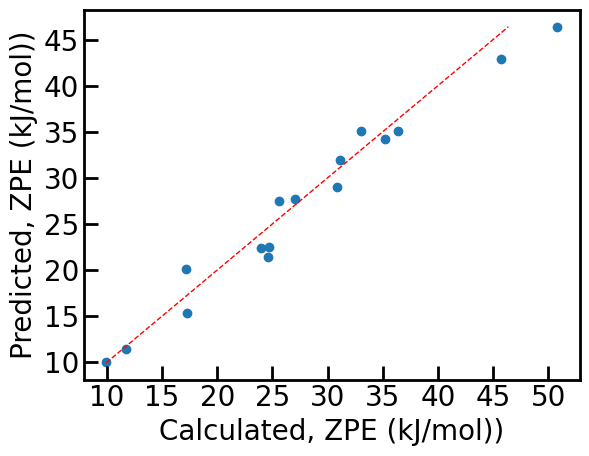

gpr3 0.9587357336658963
RMSE:  0.20409935626316225
RMSE unscaled:  2.194456736772803
----------------------------------------


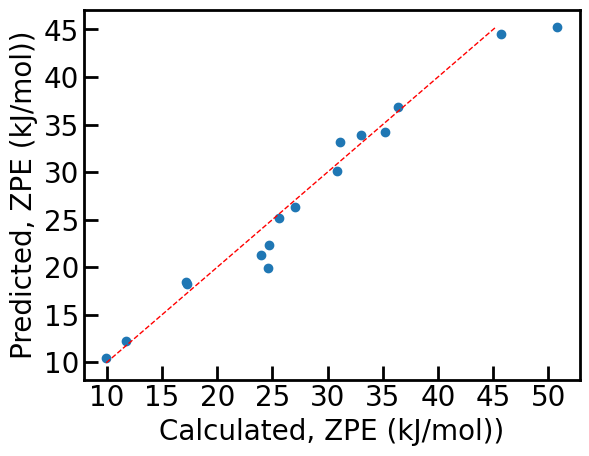

gpr4 0.9690821886676054
RMSE:  0.17666842704065017
RMSE unscaled:  1.8995220121837457
----------------------------------------


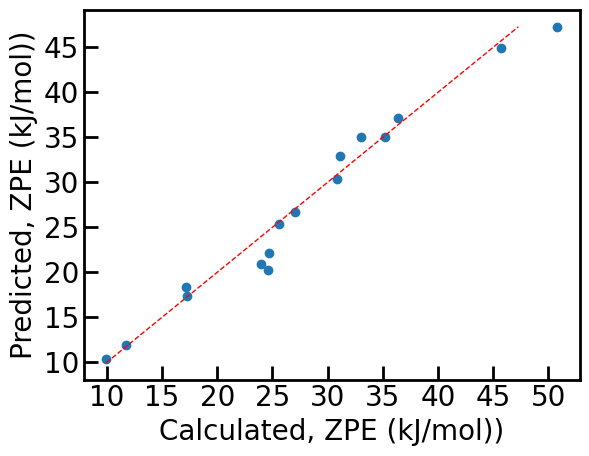

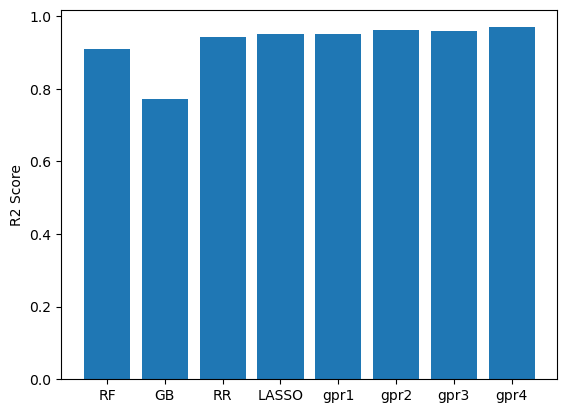

In [21]:
run_models()

In [22]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_IEII', 'X_Z', 's_X', 'mean_A2B',
       'mean_X2X', 's_A', 'A_Rvdw'], dtype=object)

In [23]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.9353689365551976
RMSE:  0.2554319518171877
RMSE unscaled:  2.746379889260945
----------------------------------------


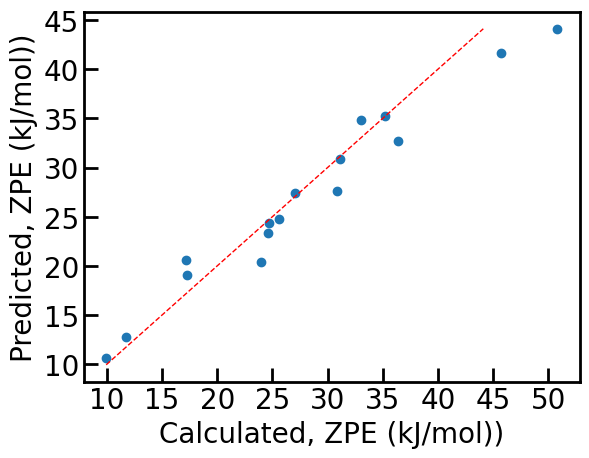

GB 0.6365366625998877
RMSE:  0.6057380791323218
RMSE unscaled:  6.512837829619647
----------------------------------------


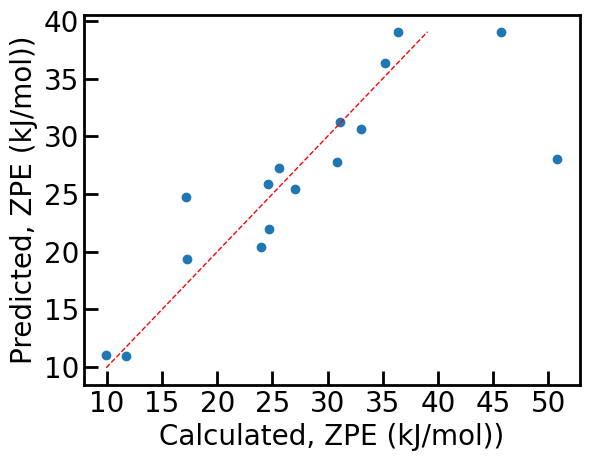

RR 0.9116848905568804
RMSE:  0.29858781224607805
RMSE unscaled:  3.210387568576189
----------------------------------------


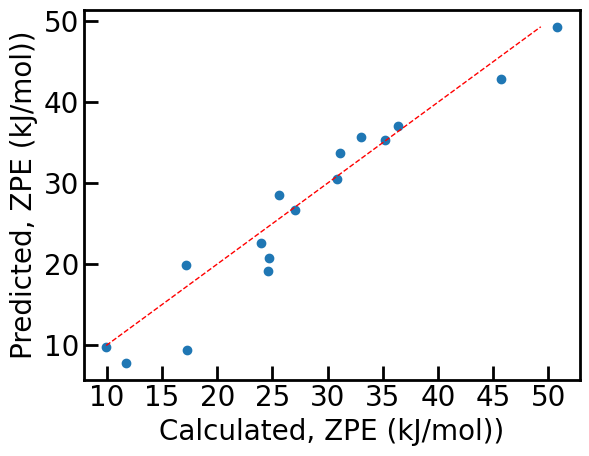

LASSO 0.9159573966093162
RMSE:  0.2912757435293566
RMSE unscaled:  3.1317689058379012
----------------------------------------


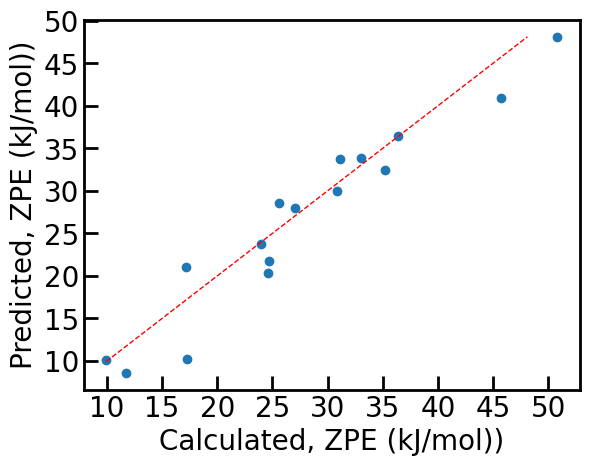

gpr1 0.916408938195926
RMSE:  0.2904922108738963
RMSE unscaled:  3.123344437746786
----------------------------------------


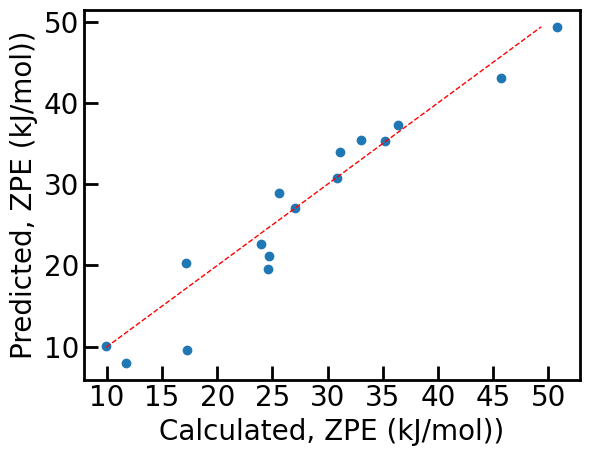

gpr2 0.9330608008297842
RMSE:  0.2599529960335298
RMSE unscaled:  2.7949897238015655
----------------------------------------


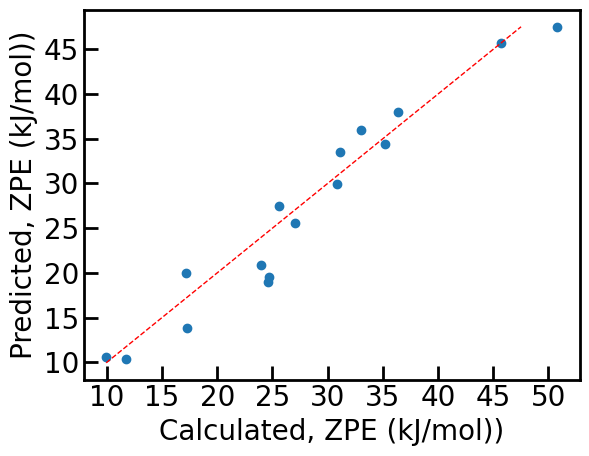

gpr3 0.9585939487492556
RMSE:  0.20444970048732816
RMSE unscaled:  2.198223604326854
----------------------------------------


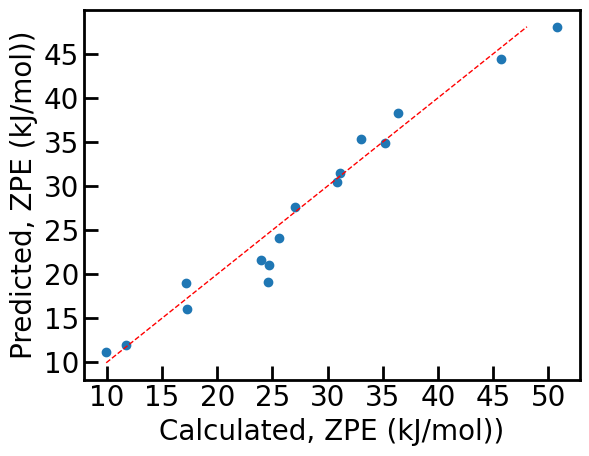

gpr4 0.9425392937845365
RMSE:  0.24084633982285036
RMSE unscaled:  2.5895567856169635
----------------------------------------


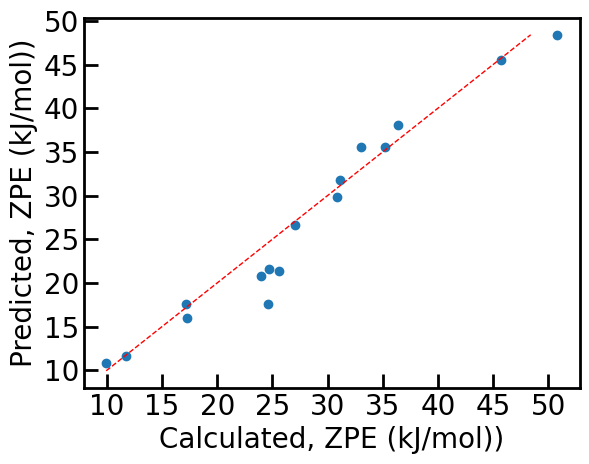

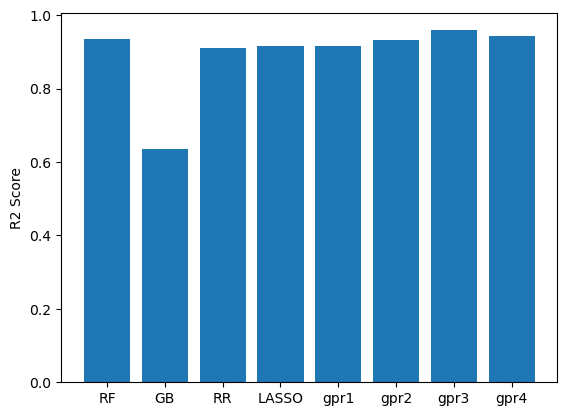

In [24]:
run_models()

# Min-Max scaling

In [25]:
data_std=d.copy()
scaler=MinMaxScaler()
scaler.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_mm= scaler.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [26]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 51)


### Test-train splitting 

In [27]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop(target)
X = df_train

Y_test = df_test.pop(target)
X_test = df_test

RF 0.9036658692987621
RMSE:  0.07219089294793299
RMSE unscaled:  3.352972956874165
----------------------------------------


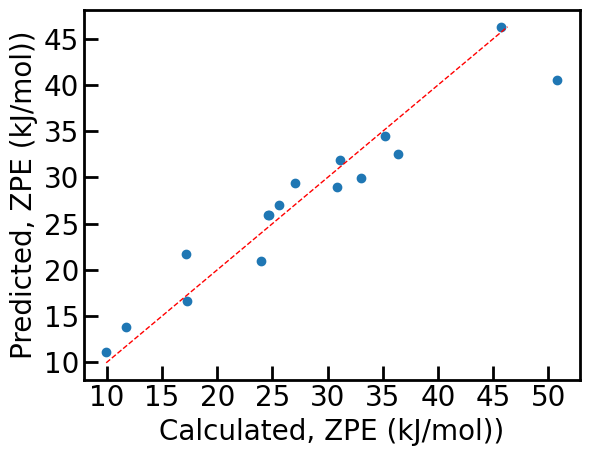

GB 0.7899729742735255
RMSE:  0.1065933014291117
RMSE unscaled:  4.950824715986301
----------------------------------------


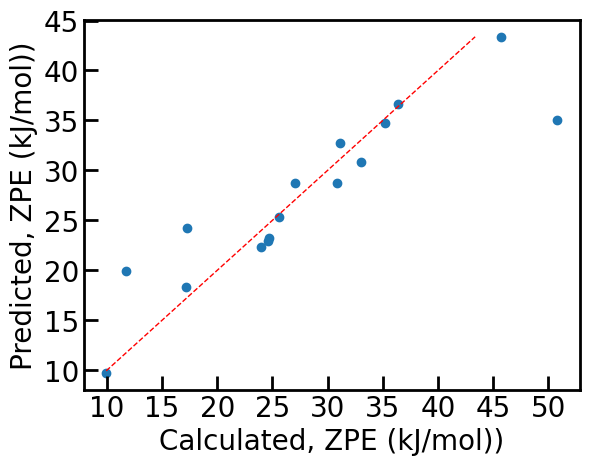

RR 0.9637789251744765
RMSE:  0.04426627616056429
RMSE unscaled:  2.055988239055925
----------------------------------------


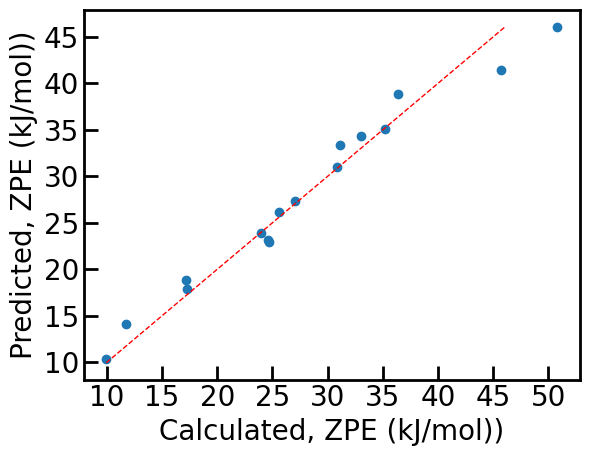

LASSO 0.5772066854684382
RMSE:  0.1512364163992542
RMSE unscaled:  7.024315582950259
----------------------------------------


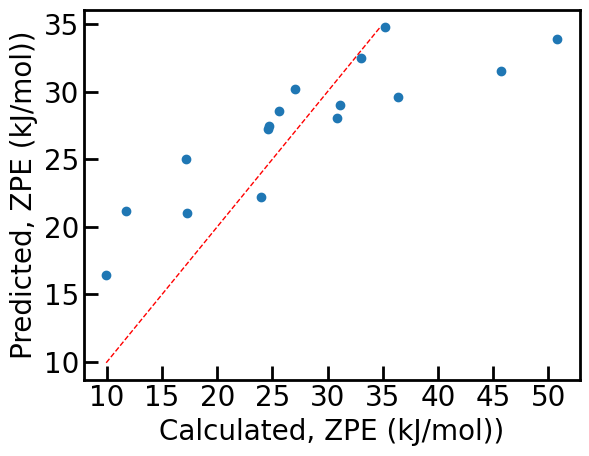

gpr1 0.9516551649995593
RMSE:  0.05114078187605959
RMSE unscaled:  2.375281030912056
----------------------------------------


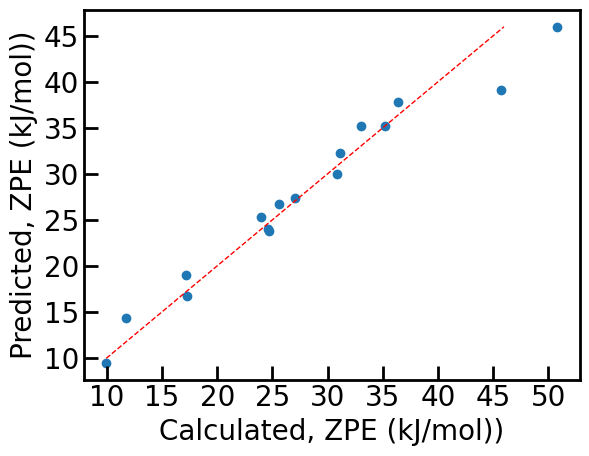

gpr2 -0.04399414024011916
RMSE:  0.23765193399166343
RMSE unscaled:  11.037964420215793
----------------------------------------


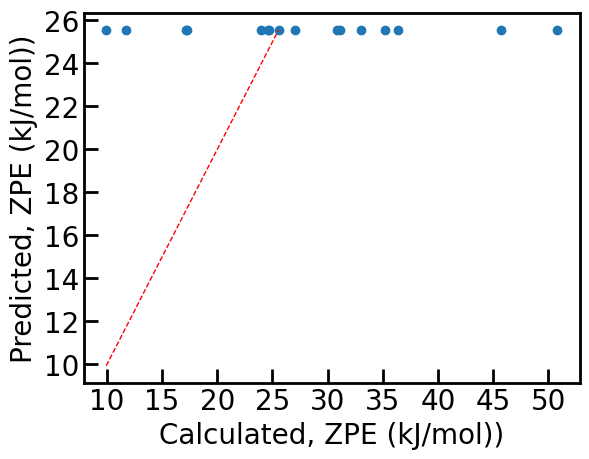

gpr3 0.957379073882316
RMSE:  0.04801796641738241
RMSE unscaled:  2.230238971523692
----------------------------------------


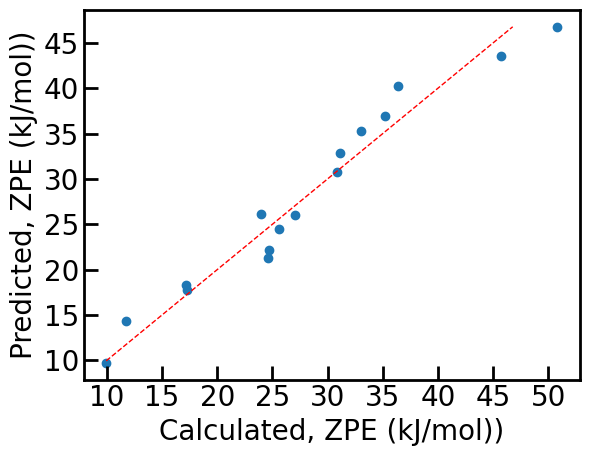

gpr4 0.9484181410590368
RMSE:  0.0528251595091845
RMSE unscaled:  2.453513511802754
----------------------------------------


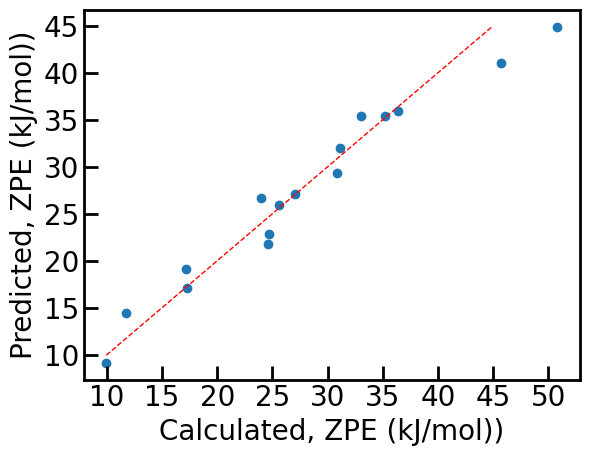

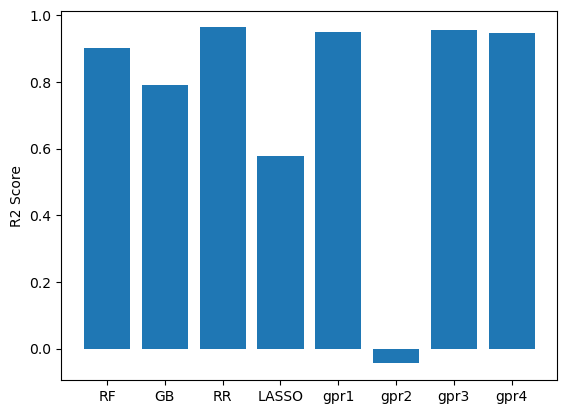

In [28]:
run_models()

## Feature selection


In [29]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
28      X_EA  81.232938
35      X_Ra  54.221020
1        s_B  45.079280
25    X_IEII  44.130829
17       X_Z  43.753926
2        s_X  36.848803
4   mean_A2B  36.476139
7   mean_X2X  21.756733
0        s_A  21.365428
33    A_Rvdw  21.351495
20     A_IEI  18.448048
16       B_Z  16.733902
42      B_Hf  16.431242
5   mean_A2X  14.661730
34      B_Ra  14.611618
10   std_B2X  14.051080
14        OF  12.789702
26      A_EA  12.359494
31    A_ChiA  12.090829
9    std_A2X  10.602250
39     B_Rho   9.731500
12     E_coh   9.463266
29    A_ChiP   9.223658
47     B_CvM   8.515155
36      B_MP   8.146515
13        TF   6.853180
11   std_X2X   5.596058
43   A_Kappa   5.555247
37      A_BP   5.551490
41      X_MV   5.384953


In [30]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_IEII', 'X_Z', 's_X', 'mean_A2B',
       'mean_X2X', 's_A', 'A_Rvdw', 'A_IEI', 'B_Z', 'B_Hf', 'mean_A2X',
       'B_Ra', 'std_B2X', 'OF', 'A_EA', 'A_ChiA', 'std_A2X', 'B_Rho',
       'E_coh', 'A_ChiP', 'B_CvM', 'B_MP', 'TF', 'std_X2X', 'A_Kappa',
       'A_BP', 'X_MV', 'std_A2B', 'B_B', 'A_G', 'A_Z', 'B_MV', 'X_Kappa',
       'A_B', 'A_CvM', 'B_IEII', 'B_Kappa'], dtype=object)

In [31]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.8755835849589743
RMSE:  0.08204104131109836
RMSE unscaled:  3.81047223045584
----------------------------------------


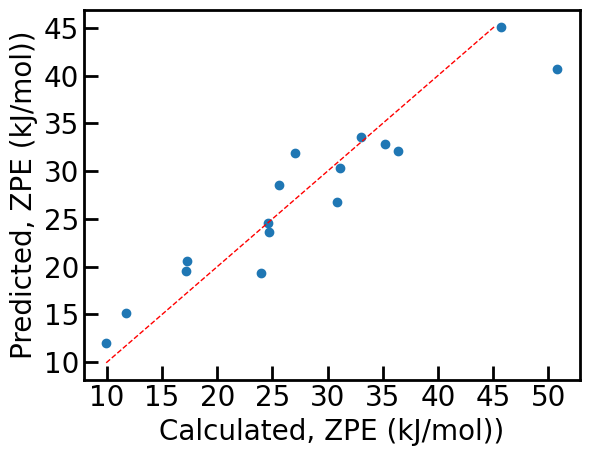

GB 0.7558466717191021
RMSE:  0.11492741721622994
RMSE unscaled:  5.3379104509393205
----------------------------------------


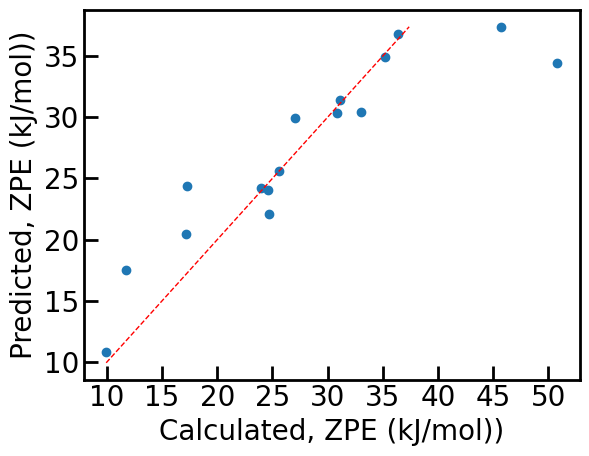

RR 0.9343341429114177
RMSE:  0.059602178111095895
RMSE unscaled:  2.7682784242804397
----------------------------------------


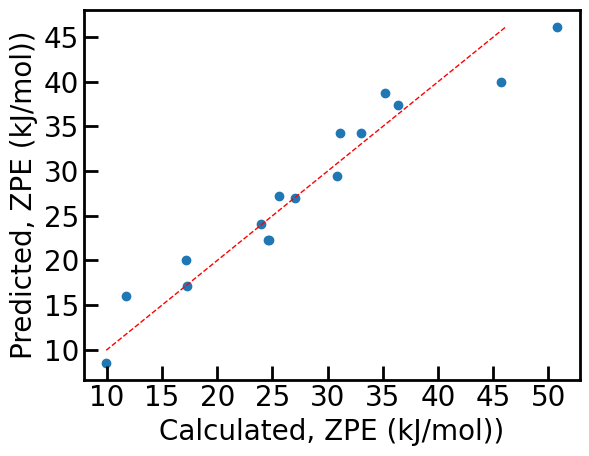

LASSO 0.5772097990371158
RMSE:  0.15123585952451213
RMSE unscaled:  7.024289718386542
----------------------------------------


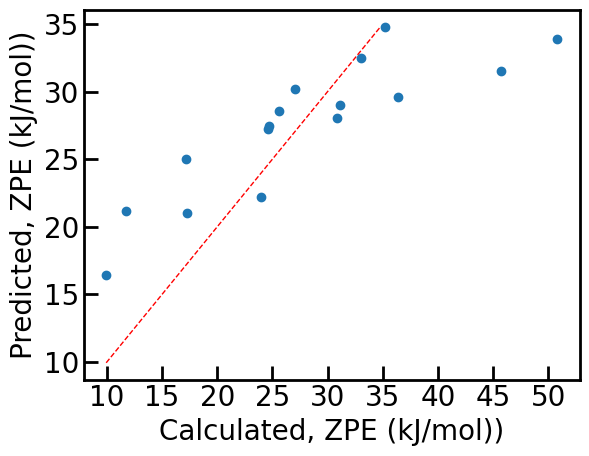

gpr1 0.924895457725398
RMSE:  0.06374196157672989
RMSE unscaled:  2.960554505663679
----------------------------------------


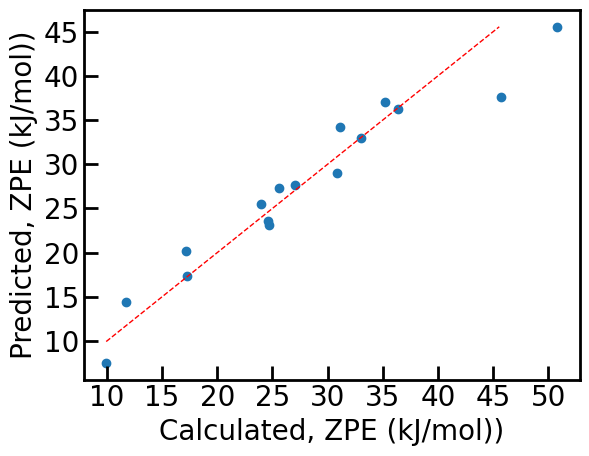

gpr2 -0.04399414369591326
RMSE:  0.23765193438499713
RMSE unscaled:  11.03796443848454
----------------------------------------


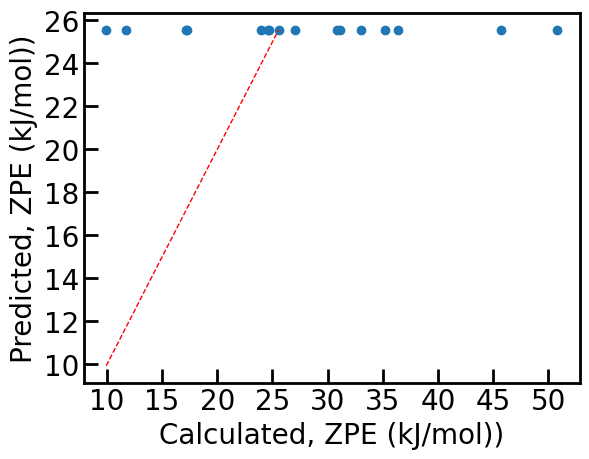

gpr3 0.951656274693437
RMSE:  0.05114019493705967
RMSE unscaled:  2.3752537699860077
----------------------------------------


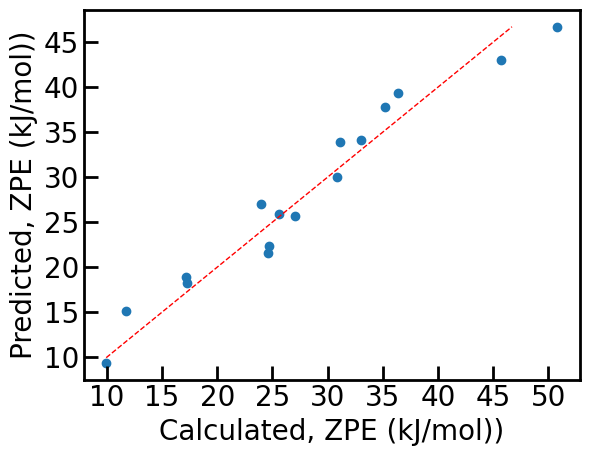

gpr4 0.9253275070424554
RMSE:  0.06355835489389795
RMSE unscaled:  2.9520267230432213
----------------------------------------


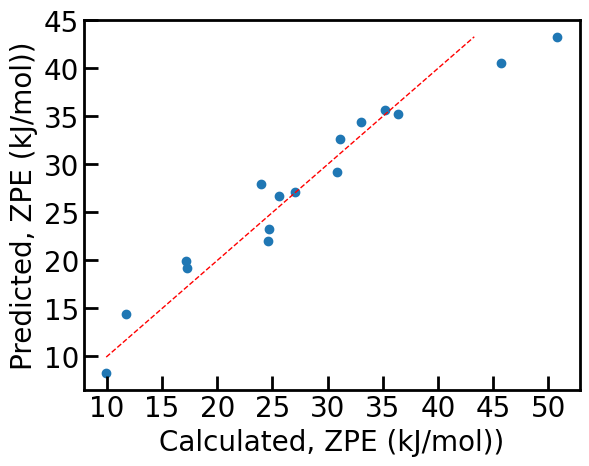

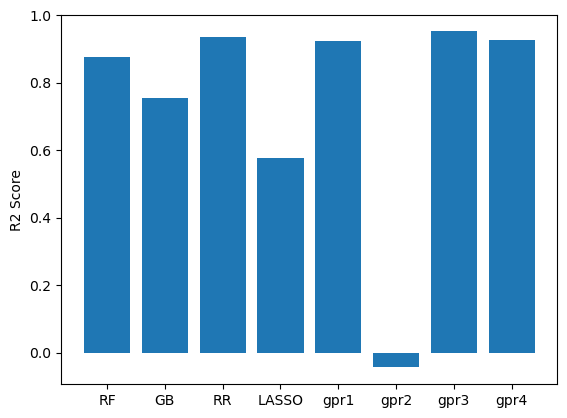

In [32]:
run_models()

In [33]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_IEII', 'X_Z', 's_X', 'mean_A2B',
       'mean_X2X', 's_A', 'A_Rvdw', 'A_IEI', 'B_Z', 'B_Hf', 'mean_A2X',
       'B_Ra', 'std_B2X', 'OF', 'A_EA', 'A_ChiA', 'std_A2X', 'B_Rho',
       'E_coh', 'A_ChiP', 'B_CvM', 'B_MP', 'TF', 'std_X2X', 'A_Kappa',
       'A_BP', 'X_MV'], dtype=object)

In [34]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.8705626834074032
RMSE:  0.08368007731843771
RMSE unscaled:  3.886598777497106
----------------------------------------


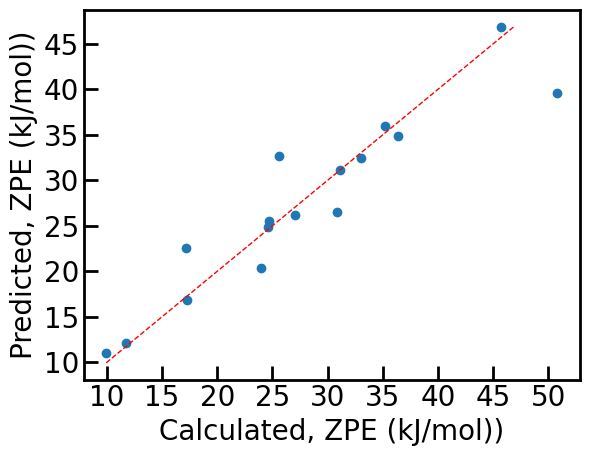

GB 0.6861522133080415
RMSE:  0.13030223275825303
RMSE unscaled:  6.0520080140005375
----------------------------------------


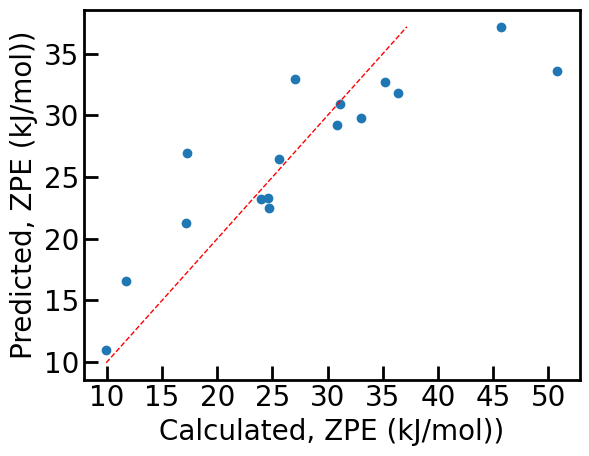

RR 0.9505555892182745
RMSE:  0.05171909600936225
RMSE unscaled:  2.402141367034239
----------------------------------------


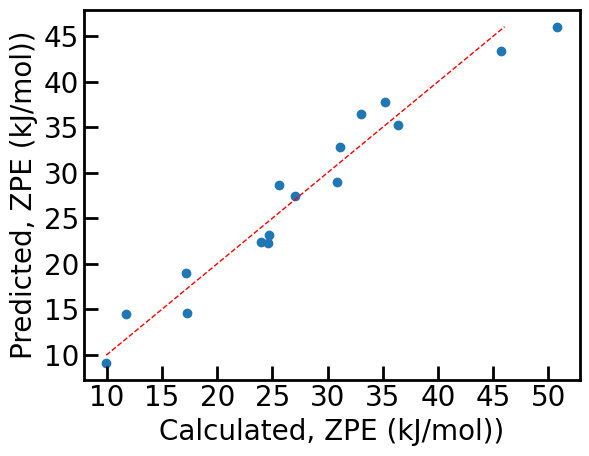

LASSO 0.5772097990371158
RMSE:  0.15123585952451213
RMSE unscaled:  7.024289718386542
----------------------------------------


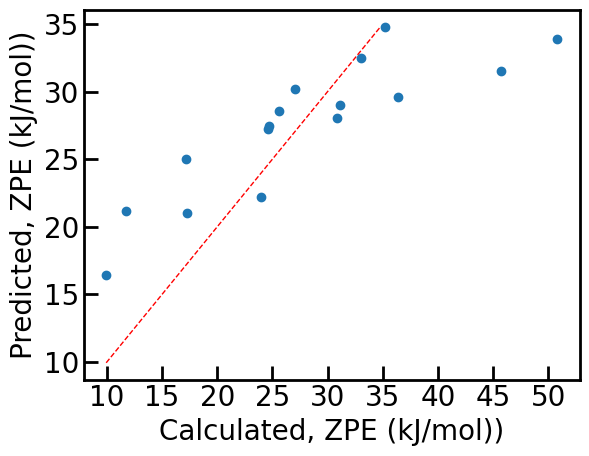

gpr1 0.9364969070544661
RMSE:  0.05861243464928404
RMSE unscaled:  2.7223088715268577
----------------------------------------


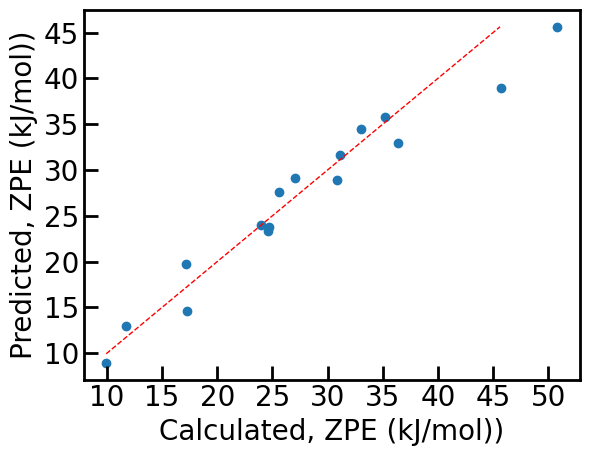

gpr2 -0.04399414713005201
RMSE:  0.23765193477586605
RMSE unscaled:  11.03796445663881
----------------------------------------


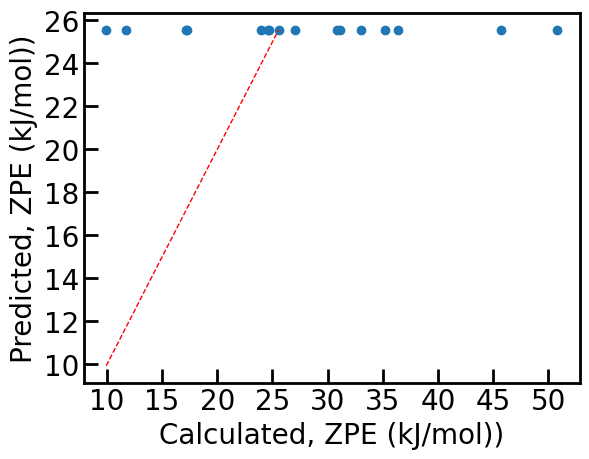

gpr3 0.9656357329068188
RMSE:  0.04311673487035019
RMSE unscaled:  2.00259672800095
----------------------------------------


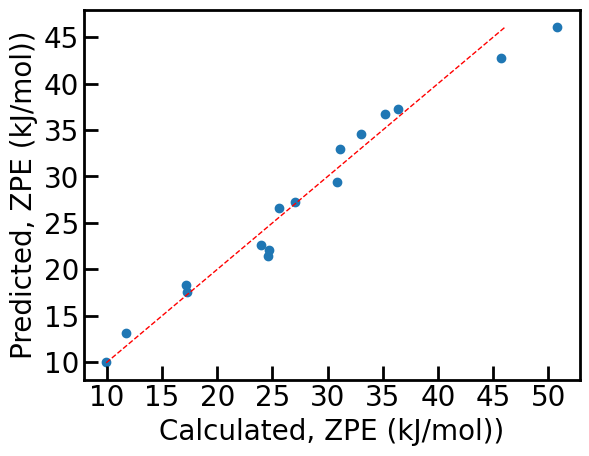

gpr4 0.9334858593210765
RMSE:  0.059985918716334095
RMSE unscaled:  2.7861016124871045
----------------------------------------


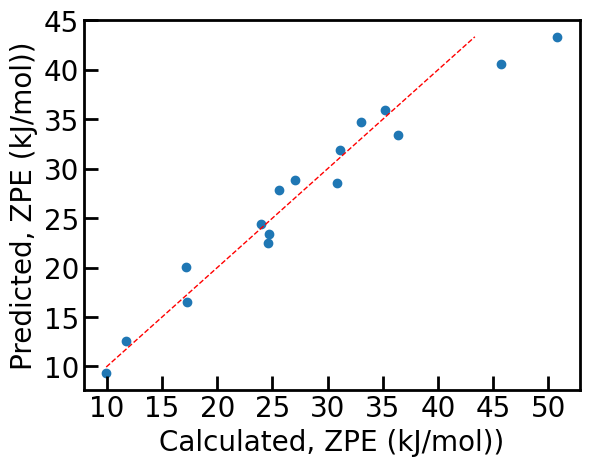

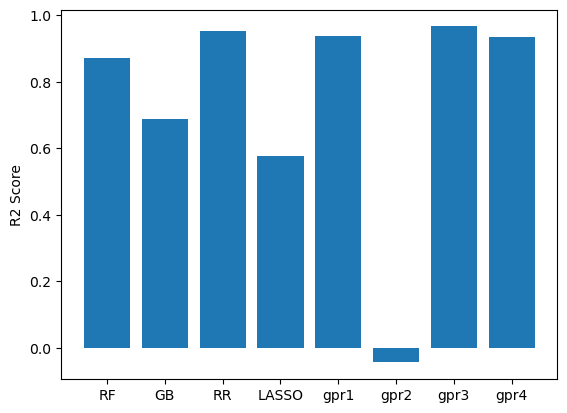

In [35]:
run_models()

In [36]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_IEII', 'X_Z', 's_X', 'mean_A2B',
       'mean_X2X', 's_A', 'A_Rvdw', 'A_IEI', 'B_Z', 'B_Hf', 'mean_A2X',
       'B_Ra', 'std_B2X', 'OF', 'A_EA', 'A_ChiA', 'std_A2X'], dtype=object)

In [37]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9054748293008129
RMSE:  0.0715098813616992
RMSE unscaled:  3.3213427423316357
----------------------------------------


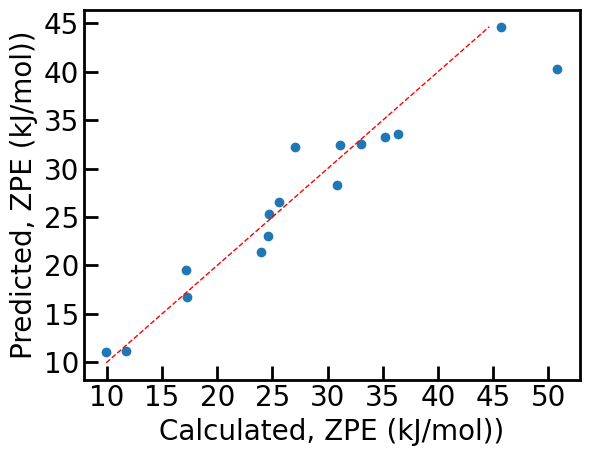

GB 0.7287422064388085
RMSE:  0.12113884673748439
RMSE unscaled:  5.626406054163361
----------------------------------------


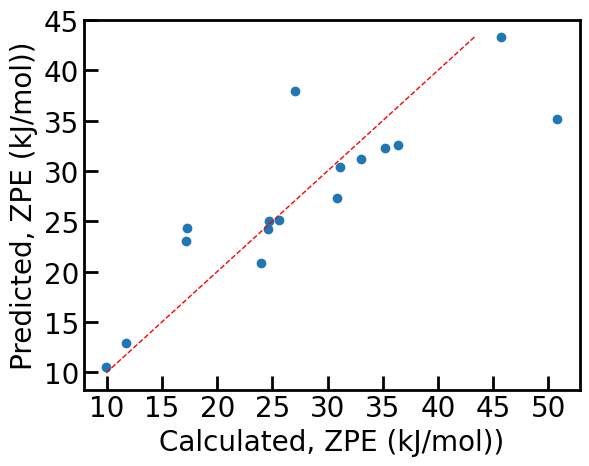

RR 0.9525193010719797
RMSE:  0.05068166500698225
RMSE unscaled:  2.3539569222440653
----------------------------------------


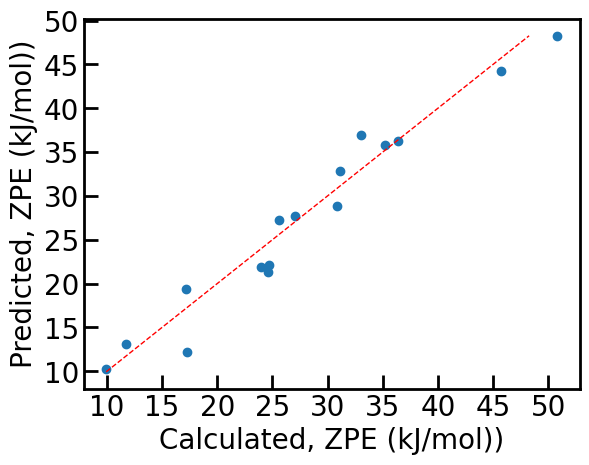

LASSO 0.5772097990371158
RMSE:  0.15123585952451213
RMSE unscaled:  7.024289718386542
----------------------------------------


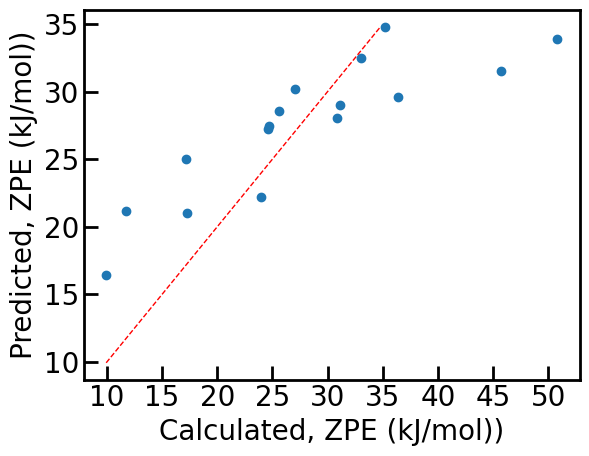

gpr1 0.9273585124652088
RMSE:  0.0626880393406855
RMSE unscaled:  2.911604110235632
----------------------------------------


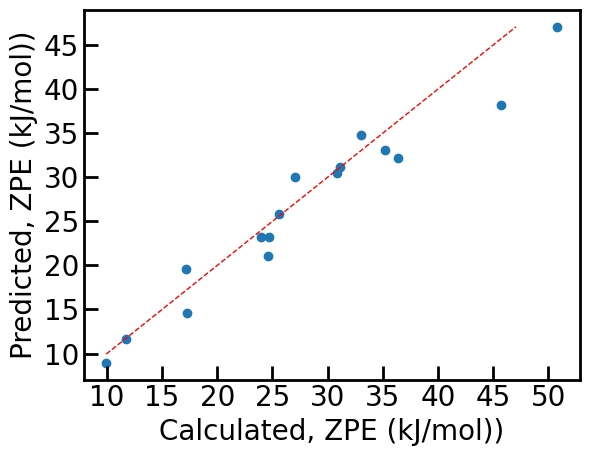

gpr2 -0.043994140664998405
RMSE:  0.2376519340400226
RMSE unscaled:  11.037964422461881
----------------------------------------


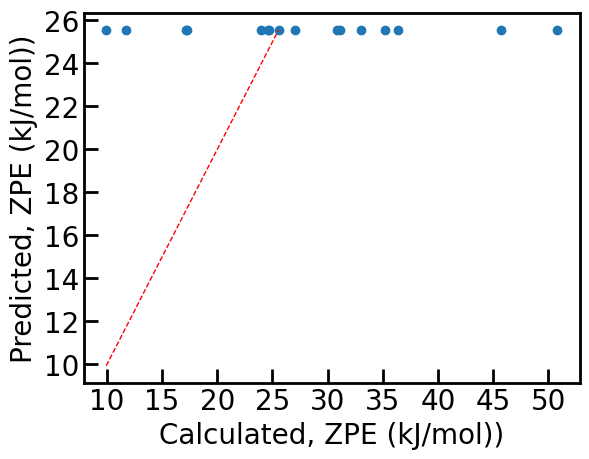

gpr3 0.9627267977714674
RMSE:  0.044904583770288616
RMSE unscaled:  2.085635027815225
----------------------------------------


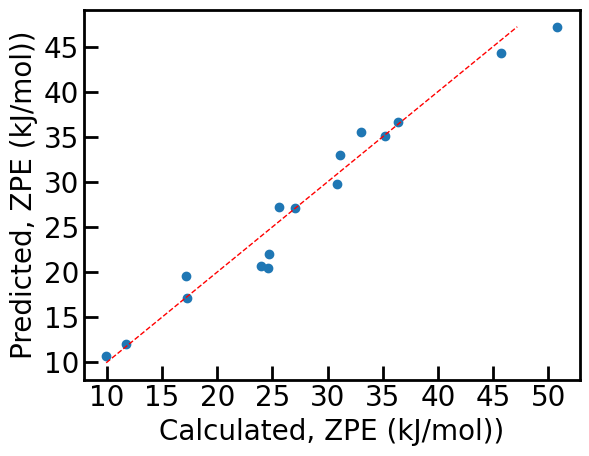

gpr4 0.9533797111767092
RMSE:  0.05022035776315958
RMSE unscaled:  2.3325310795901566
----------------------------------------


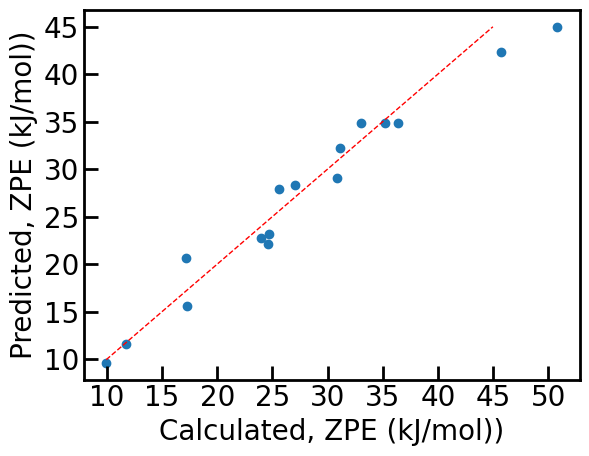

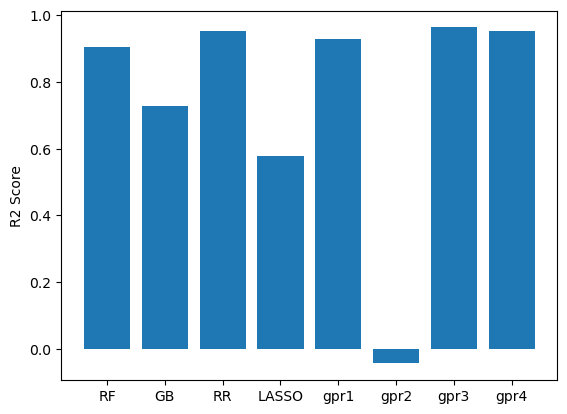

In [38]:
run_models()

In [39]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_IEII', 'X_Z', 's_X', 'mean_A2B',
       'mean_X2X', 's_A', 'A_Rvdw'], dtype=object)

In [40]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.9244558984458409
RMSE:  0.06392821858651163
RMSE unscaled:  2.9692053851766524
----------------------------------------


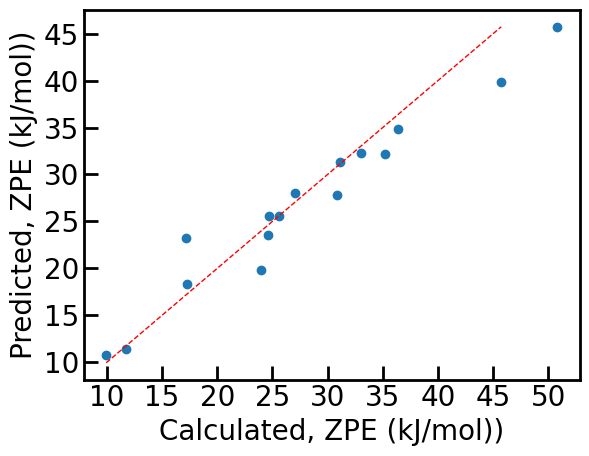

GB 0.6601942071356219
RMSE:  0.13558377184341014
RMSE unscaled:  6.297313993744797
----------------------------------------


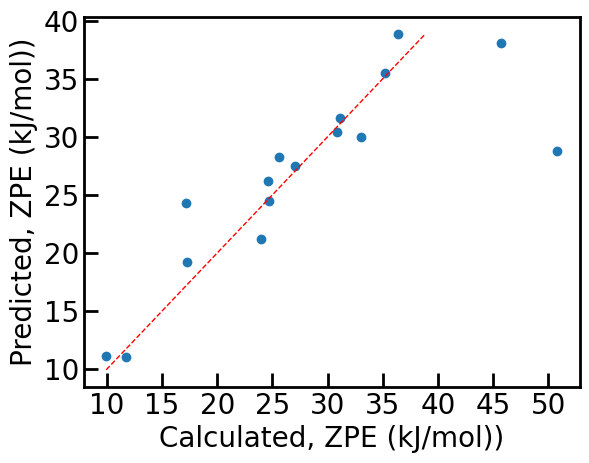

RR 0.9132429853245323
RMSE:  0.06850852577419257
RMSE unscaled:  3.1819419992748754
----------------------------------------


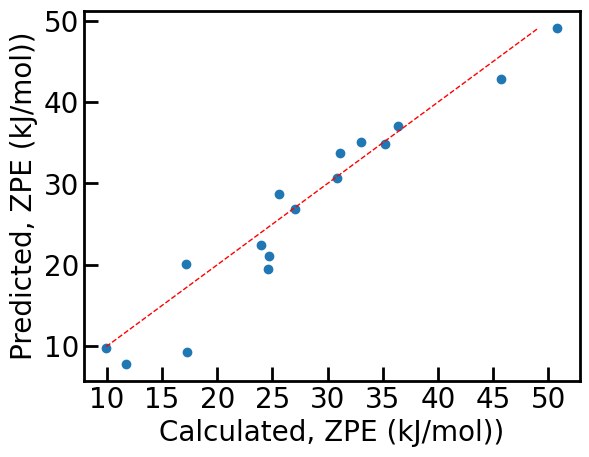

LASSO 0.5335561399138484
RMSE:  0.1588517533331862
RMSE unscaled:  7.378016967630115
----------------------------------------


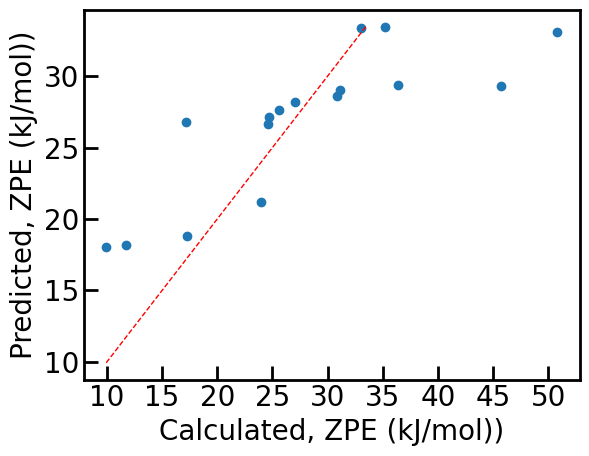

gpr1 0.9180630115296311
RMSE:  0.06657824166792069
RMSE unscaled:  3.092288164239455
----------------------------------------


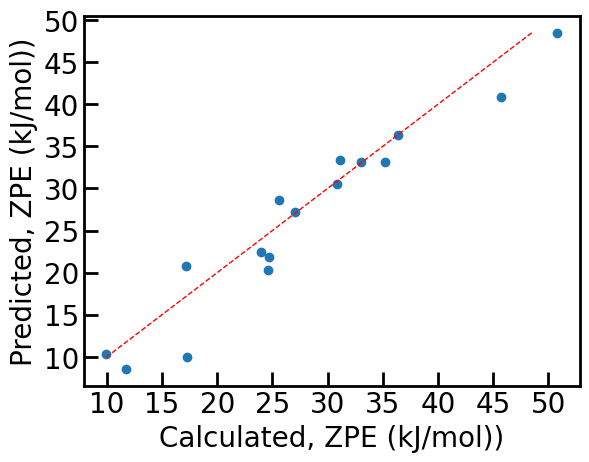

gpr2 -0.043994048617501
RMSE:  0.23765192356330372
RMSE unscaled:  11.037963935860958
----------------------------------------


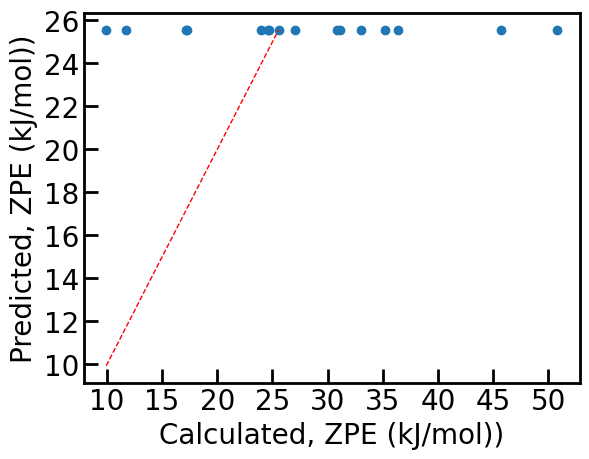

gpr3 0.923490214748363
RMSE:  0.0643355197502339
RMSE unscaled:  2.988122865366974
----------------------------------------


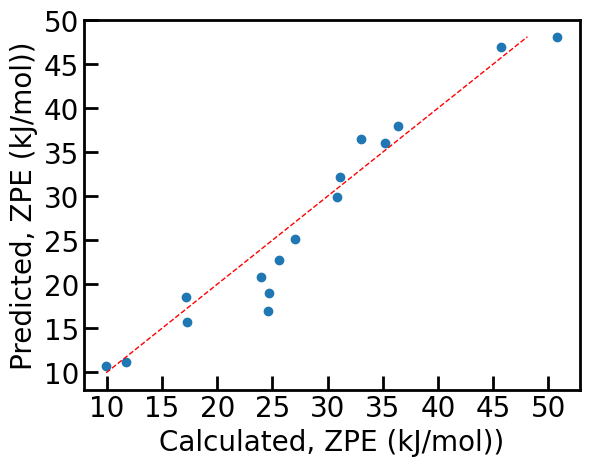

gpr4 0.9370179323601453
RMSE:  0.05837149000651044
RMSE unscaled:  2.7111179741943325
----------------------------------------


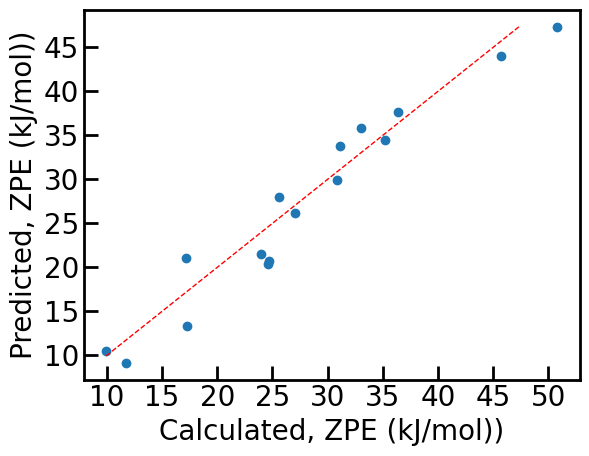

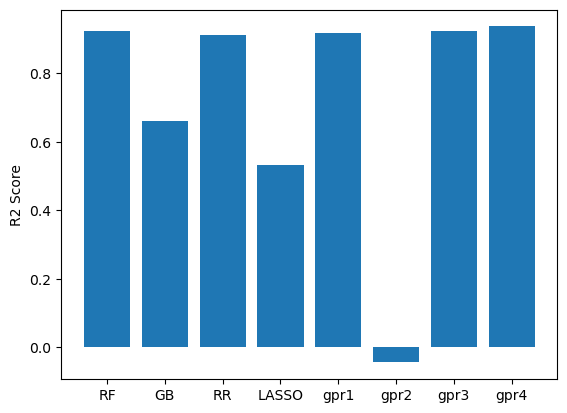

In [41]:
run_models()